# 📉 Math & Stats for ML: Fixed-Step Gradient Descent
## Implementing Optimization Algorithms from Scratch

This notebook implements the **Fixed-Step Gradient Descent** algorithm to solve the optimization problems assigned in class. Instead of using "black-box" solvers (like `scipy.optimize`), we manually calculate gradients and iteratively update our position to find the minima.

### 🧠 The Algorithm: Gradient Descent
For a cost function $J(v)$, we update the parameters $v$ at every step $t$ using the rule:

$$v_{t+1} = v_t - \alpha \cdot \nabla J(v_t)$$

* **$\nabla J(v)$ (The Gradient):** A vector containing the partial derivatives. It points in the direction of the steepest *ascent*. We subtract it to move *downhill*.
* **$\alpha$ (Alpha / Learning Rate):** A fixed number that determines how big of a step we take.
    * **If $\alpha$ is too small:** The algorithm takes forever to converge.
    * **If $\alpha$ is too large:** The algorithm overshoots, oscillates, or diverges (explodes).

---

### 1️⃣ Exercise E1: The Rosenbrock Function ($J_R$)
*Also known as the "Banana Function."*

$$J_R(v) = \sum_{i=1}^{N-1} (v_{i+1} - v_i^2)^2 + (v_i - 1)^2$$

* **The Challenge:** The global minimum lies inside a long, narrow, flat parabolic valley.
* **What to observe:** Fixed-step gradient descent often struggles here. If the step size is large, it bounces back and forth across the valley walls (oscillation) rather than moving down the valley floor.

### 2️⃣ Exercise E2: The Coupled System ($J_H$)
$$J_H(x, y) = (x^2 + y - 2)^2 + (y^2 - 2x + 1)^2$$

* **The Goal:** Find the coordinates $(x, y)$ that minimize this function. This is equivalent to solving the system of non-linear equations where both terms inside the squares are zero.
* **What to observe:** We will visualize the "trajectory"—the path the algorithm takes from a starting point to the bottom of the basin.

### 3️⃣ Exercise E3: The Penalty Method ($J_{EPS}$)
This introduces **Constrained Optimization** using a penalty term.

$$J_{EPS}(v) = \underbrace{\sum_{i=1}^N v_i^2}_{\text{minimize size}} + \underbrace{\frac{1}{\varepsilon} \sum_{i=1}^{N-1} (v_{i+1} + v_i - N)^2}_{\text{penalty for constraint violation}}$$

* **The Logic:** We want the vector $v$ to be small (close to 0), **BUT** we also strictly require that neighbors sum to $N$ ($v_{i+1} + v_i = N$).
* **The Hyperparameter $\varepsilon$:**
    * As $\varepsilon \to 0$, the penalty term becomes huge.
    * **Gradients Explode:** Because we divide by a tiny $\varepsilon$, the gradient values become massive. To prevent the algorithm from crashing, we must drastically **reduce the learning rate $\alpha$** when $\varepsilon$ is small.

Gradient Descent Algorithm defined.

--- E1: ROSENBROCK FUNCTION ---
Start: [-1.5, 2.5]
End:   [1.    0.999]
Steps: 2001


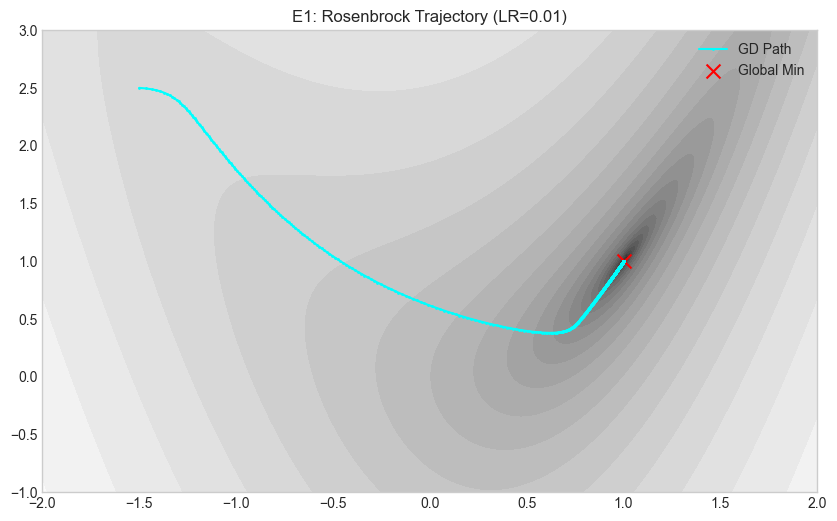


--- E2: FUNCTION J_H ---
Start: [0.0, 0.0]
End:   [1. 1.]


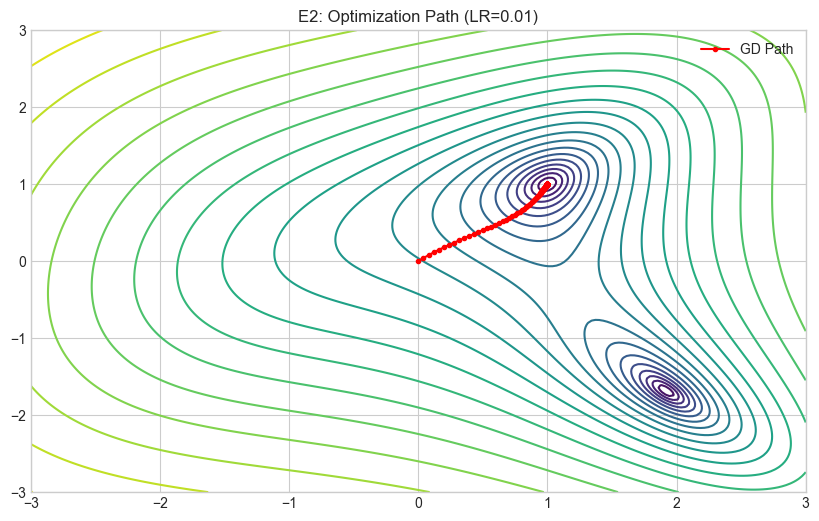


--- E3: PENALTY METHOD GRADIENTS ---
Epsilon: 0.1
Final Vector: [1.91 2.9  2.   2.9  1.91]
Constraint Check (v_i + v_i+1): [4.81 4.9  4.9  4.81]
Target was: 5


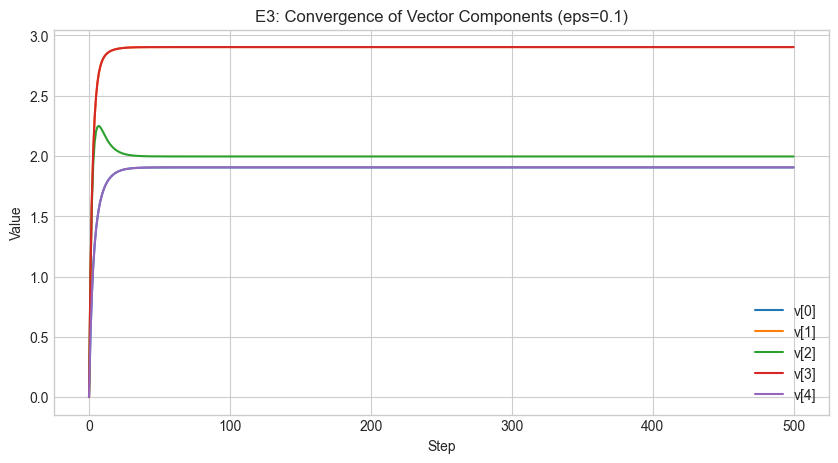

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, diff, lambdify

# Styling
plt.style.use('seaborn-v0_8-whitegrid')

# ==============================================================================
# 0. THE ALGORITHM: Fixed-Step Gradient Descent
# ==============================================================================
def gradient_descent(start_point, grad_func, learning_rate, n_steps):
    """
    Performs fixed-step gradient descent.
    
    Args:
        start_point: The initial coordinate (numpy array)
        grad_func: A function that takes vector v and returns gradient vector dv
        learning_rate: The fixed step size (alpha)
        n_steps: How many iterations to run
        
    Returns:
        history: A list of all points visited (for plotting)
    """
    path = [start_point]
    current_v = np.array(start_point, dtype=float)
    
    for i in range(n_steps):
        # 1. Compute Gradient at current point
        grad = grad_func(current_v)
        
        # 2. Update Rule: v_new = v_old - alpha * grad
        current_v = current_v - learning_rate * grad
        
        path.append(current_v)
        
        # Safety break if values explode (NaN or Infinity)
        if np.any(np.isnan(current_v)) or np.max(np.abs(current_v)) > 1e10:
            print(f"⚠️ Diverged at step {i}! Step size might be too large.")
            break
            
    return np.array(path)

print("Gradient Descent Algorithm defined.")

# ==============================================================================
# E1: ROSENBROCK (N=2)
# ==============================================================================
print("\n--- E1: ROSENBROCK FUNCTION ---")

# 1. Define the Gradient Analytically
def grad_rosenbrock(v):
    x, y = v[0], v[1]
    # J = (y - x^2)^2 + (x - 1)^2
    # dJ/dx = 2(y - x^2)(-2x) + 2(x - 1)
    # dJ/dy = 2(y - x^2)
    grad_x = -4 * x * (y - x**2) + 2 * (x - 1)
    grad_y = 2 * (y - x**2)
    return np.array([grad_x, grad_y])

# 2. Run Gradient Descent
start_pos = [-1.5, 2.5]
lr = 0.01  
steps = 2000

path_r = gradient_descent(start_pos, grad_rosenbrock, lr, steps)

print(f"Start: {start_pos}")
print(f"End:   {np.round(path_r[-1], 3)}")
print(f"Steps: {len(path_r)}")

# 3. Visualize Trajectory
plt.figure(figsize=(10, 6))
# Create background map
x_grid = np.linspace(-2, 2, 200)
y_grid = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x_grid, y_grid)
Z = (Y - X**2)**2 + (X - 1)**2

plt.contourf(X, Y, np.log(Z + 1e-5), levels=30, cmap='gray')
plt.plot(path_r[:, 0], path_r[:, 1], color='cyan', marker='.', markersize=2, label='GD Path')
plt.scatter([1], [1], c='red', marker='x', s=100, label='Global Min')
plt.title(f'E1: Rosenbrock Trajectory (LR={lr})')
plt.legend()
plt.show()


# ==============================================================================
# E2: COUPLED FUNCTION J_H
# ==============================================================================
print("\n--- E2: FUNCTION J_H ---")

# 1. Define Gradient Analytically
def grad_h(v):
    x, y = v[0], v[1]
    # J = (x^2 + y - 2)^2 + (y^2 - 2x + 1)^2
    
    # Term 1 derivatives
    # d/dx (x^2 + y - 2)^2 = 2(x^2 + y - 2) * 2x
    # d/dy (x^2 + y - 2)^2 = 2(x^2 + y - 2) * 1
    
    # Term 2 derivatives
    # d/dx (y^2 - 2x + 1)^2 = 2(y^2 - 2x + 1) * (-2)
    # d/dy (y^2 - 2x + 1)^2 = 2(y^2 - 2x + 1) * 2y
    
    gx = 2*(x**2 + y - 2)*(2*x) + 2*(y**2 - 2*x + 1)*(-2)
    gy = 2*(x**2 + y - 2)*(1)  + 2*(y**2 - 2*x + 1)*(2*y)
    
    return np.array([gx, gy])

# 2. Run GD
start_pos = [0.0, 0.0] 
lr = 0.01 
path_h = gradient_descent(start_pos, grad_h, lr, 200)

print(f"Start: {start_pos}")
print(f"End:   {np.round(path_h[-1], 3)}")

# 3. Visualize
plt.figure(figsize=(10, 6))
x_grid = np.linspace(-3, 3, 200)
y_grid = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x_grid, y_grid)
Z = (X**2 + Y - 2)**2 + (Y**2 - 2*X + 1)**2

plt.contour(X, Y, np.log(Z+0.1), levels=20, cmap='viridis')
plt.plot(path_h[:, 0], path_h[:, 1], 'r.-', label='GD Path')
plt.title(f'E2: Optimization Path (LR={lr})')
plt.legend()
plt.show()


# ==============================================================================
# E3: PENALTY METHOD (Manual Gradient)
# ==============================================================================
print("\n--- E3: PENALTY METHOD GRADIENTS ---")

# 1. Define Gradient
def grad_eps(v, epsilon, N):
    """
    Manual gradient calculation for E3.
    J = Sum(v_i^2) + (1/eps) * Sum(v_{i+1} + v_i - N)^2
    """
    # Gradient of first term (Sum v_i^2) is just 2*v
    grad = 2 * v.copy()
    
    # Gradient of second term (Penalty)
    # We iterate to add the contributions of the constraints
    penalty_grad = np.zeros_like(v)
    
    # The constraint term is: (1/eps) * sum_{i=1}^{N-1} (v_{i+1} + v_i - N)^2
    # Note: Using 0-indexing, so i goes 0 to N-2
    
    coeff = 2.0 / epsilon
    
    # We loop through the constraints and add derivatives to the relevant variables
    for i in range(len(v) - 1):
        # The term is (v[i+1] + v[i] - N)^2
        inner = (v[i+1] + v[i] - N)
        
        # Derivative w.r.t v[i]
        penalty_grad[i] += coeff * inner
        
        # Derivative w.r.t v[i+1]
        penalty_grad[i+1] += coeff * inner
        
    return grad + penalty_grad

# 2. Experiment
N_dim = 5
epsilon = 0.1  # Try making this 0.01 - you will need to LOWER learning_rate!
learning_rate = 0.005 # Small LR is needed for small Epsilon
steps = 500

# Wrapper to match our generic GD function signature
func_to_optimize = lambda v: grad_eps(v, epsilon, N_dim)

start_v = np.zeros(N_dim)
path_eps = gradient_descent(start_v, func_to_optimize, learning_rate, steps)

final_v = path_eps[-1]
print(f"Epsilon: {epsilon}")
print(f"Final Vector: {np.round(final_v, 2)}")
print(f"Constraint Check (v_i + v_i+1): {np.round(final_v[:-1] + final_v[1:], 2)}")
print(f"Target was: {N_dim}")

# 3. Plot convergence of the vector components
plt.figure(figsize=(10, 5))
for i in range(N_dim):
    plt.plot(path_eps[:, i], label=f'v[{i}]')
plt.title(f'E3: Convergence of Vector Components (eps={epsilon})')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.show()